# Using osmium and pyrosm

* https://osmcode.org/osmium-tool/manual.html
* https://pyrosm.readthedocs.io/en/latest/basics.html#read-landuse

## extract bbox using osmium

```osmium extract -b -8.5,53.7,-7.2,54.9 /storage/osm/ireland-and-northern-ireland-latest.osm.pbf -o leitrim.pbf```


In [15]:
import sys,os
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

import geopandas as gpd
import json
from shapely.geometry import Polygon, box
import nbimporter
from gridding import *

In [2]:
counties = gpd.read_file('data/counties.shp')
counties=counties.to_crs("EPSG:4286")
leitrim=counties[counties.NAME_TAG.isin(['Leitrim','Cavan','Fermanagh'])]

<AxesSubplot:>

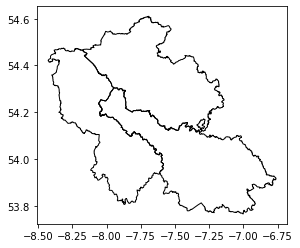

In [3]:
leitrim.plot(color='none')

In [8]:
from pyrosm import OSM
from pyrosm import get_data

pbf_file='leitrim.pbf'
#bbox = list(leitrim.to_crs('WGS84').bounds.iloc[0])
bbox = [-8.42, 53.80, -7.0, 54.6]
print (bbox)
osm = OSM(pbf_file,bbox)

[-8.42, 53.8, -7.0, 54.6]


In [17]:
#landuse = osm.get_landuse()
x=landuse.landuse.value_counts()[:1].index
#print (x)
forest = landuse[landuse.landuse=='forest']
forest['area'] = forest.to_crs('EPSG:6933').geometry.area/10**6

/home/damien/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
natural = osm.get_natural()
natural.natural.value_counts()
#df2 = natural[natural.natural.isin(['wood','heath','wetland','water','scrub'])]
#df2['landuse']=df2.natural

In [22]:
gdf = forest

In [ ]:
#roads=osm.get_network()

<AxesSubplot:>

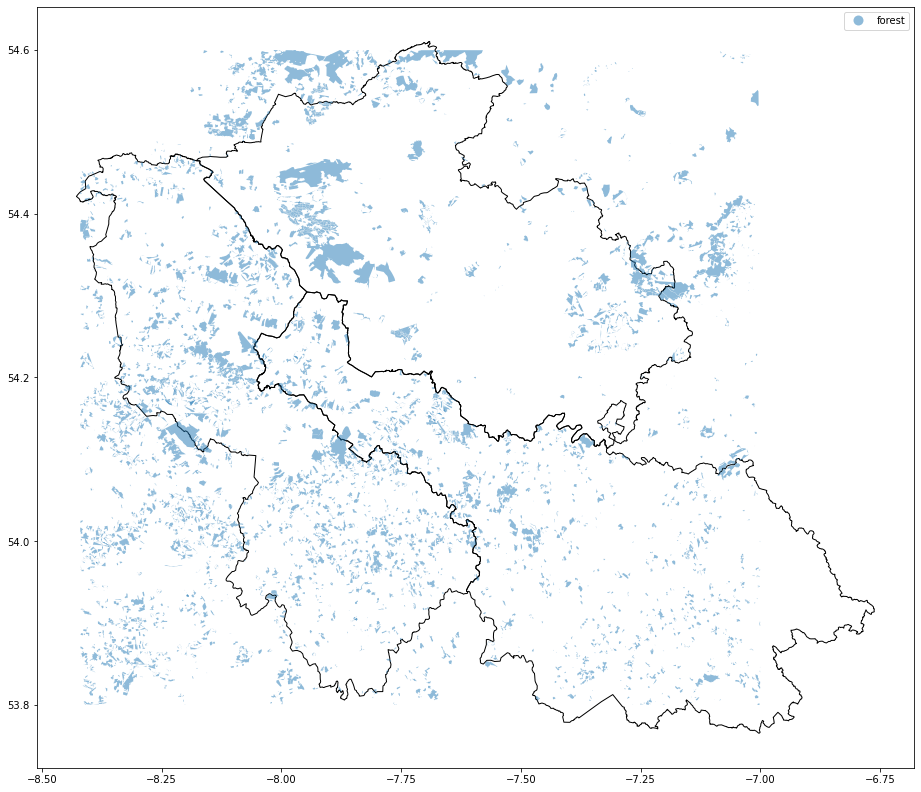

In [11]:
fig,ax=plt.subplots(figsize=(25,14))
leitrim.plot(color='none',ax=ax)
#landuse.plot(column='landuse', legend=True, ax=ax)
gdf.plot(column='landuse',legend=True, alpha=0.5,ax=ax)

In [ ]:
import geoplot as gplt
import geoplot.crs as gcrs
cent = gdf.centroid
cent['x'] = cent.geometry.x
cent['y'] = cent.geometry.y
m=cent
ax=gplt.kdeplot(m, projection=gcrs.Mercator(), lw=1, figsize=(10,10))
#gplt.polyplot(gdf,projection=gcrs.Mercator(), ax=ax)

/home/damien/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:4286

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
gridding.ipynb:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ]
gridding.ipynb:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3857

  {
/home/damien/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In 

(-8.543431356375004, -6.677033221125, 53.7123223637096, 54.70416362963437)

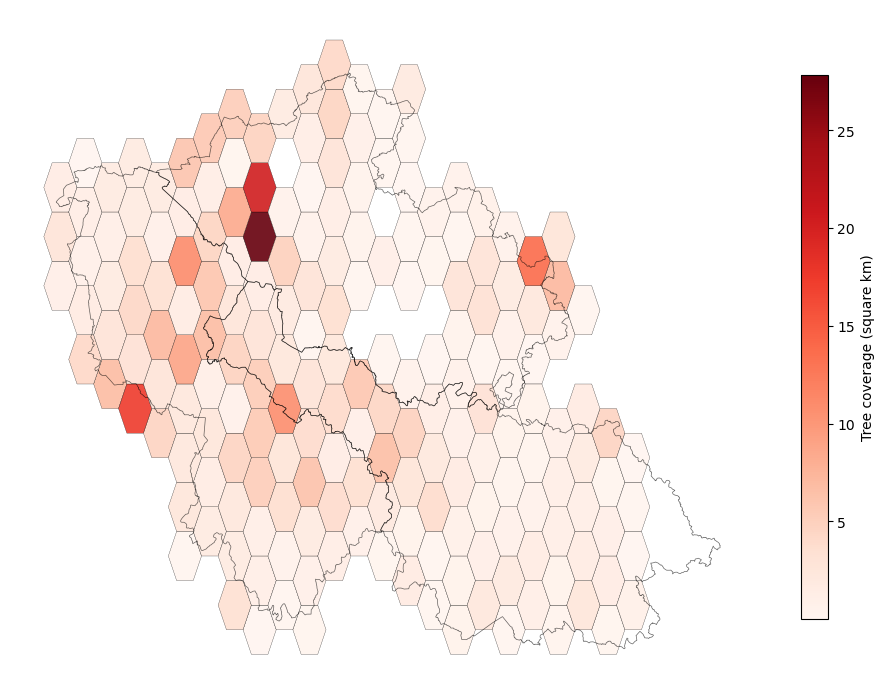

In [35]:
grid = grid_summary(leitrim, gdf, n_cells=40)
fig,ax=plt.subplots(1,1,figsize=(12,12))
grid.plot(column='value',ec='black',lw=0.2,legend=True, cmap='Reds',alpha=0.9,
          legend_kwds={'label': "Tree coverage (square km)", "shrink": .6},
          ax=ax)
leitrim.plot(fc='none',lw=.5,ax=ax,alpha=0.6)

ax.axis('off')

In [ ]:
fig,ax=plt.subplots(figsize=(25,14))
gdf.plot(column='landuse',legend=True, alpha=0.8,cmap='Spectral_r',ax=ax)
#roads.plot(color='gray',ax=ax)
ax.set_xlim(-8.4,-7.8)
ax.set_ylim(53.9,54.0)

In [ ]:
def view_area(df, bbox):
    """view farm parcels"""
    
    import folium
    lon = bbox[0]+bbox[0]-bbox[2]
    lat = bbox[1]+bbox[1]-bbox[3]
    print (lon,lat)
    print (gdf.centroid)
    m=folium.Map(location=[lon,lat], 
                  width=800, height=500,zoom_start=12)   
    geoj = folium.GeoJson(data=df)
    geoj.add_to(m)
    folium.TileLayer(
            tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Satellite',
            overlay = True,
            control = True
    ).add_to(m)
    folium.LayerControl().add_to(m)
    return m

view_area(gdf[:10],bbox)